In [1]:
import tensorflow as tf
import tensorflow.keras as keras 
import numpy as np
import pandas as pd
import  matplotlib.pyplot as pyplot
from PIL import Image
import random
import os
import glob

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

Num GPUs Available:  1


## Dataset

### global variables

In [3]:
image_size=(600,600)

### Utils

In [4]:
# Open image and process to numpy
def open_image(image_path):
    img=Image.open(image_path)
    img=img.resize(image_size)
    return np.array(img,dtype=np.float32)/255

### Trainning dataset

In [5]:
training_dataset_path="dataset/training_set/"

In [6]:
training_cats=glob.glob(training_dataset_path+"cats/*.jpg",recursive=True)
training_dogs=glob.glob(training_dataset_path+"dogs/*.jpg",recursive=True)

training Generator

In [7]:
def training_gen():
    def training_cats_gen():
        for training_cat in training_cats:
            yield open_image(training_cat)
    def training_dogs_gen():
        for training_dog in training_dogs:
            yield open_image(training_dog)
    training_cats_gen=training_cats_gen()
    training_dogs_gen=training_dogs_gen()
    dogs=0
    cats=0
#     Pick one
    for _ in range(len(training_cats)+len(training_dogs)):
        if len(training_cats)>cats and len(training_dogs)>dogs:
            picking=bool(random.getrandbits(1))
            if picking:
                dogs+=1
                yield next(training_dogs_gen),0
            else:
                cats+=1
                yield next(training_cats_gen),1
        elif len(training_cats)>cats:
            cats+=1
            yield next(training_cats_gen),1
        elif len(training_dogs)>dogs:
            dogs+=1
            yield next(training_dogs_gen),0

In [8]:
training_dataset=tf.data.Dataset.from_generator(
    training_gen,
    output_signature=(
        tf.TensorSpec(shape=(image_size[1],image_size[0], 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).batch(8).prefetch(tf.data.experimental.AUTOTUNE)

## Test set

In [9]:
test_dataset_path="dataset/test_set/"

In [10]:
test_cats=glob.glob(test_dataset_path+"cats/*.jpg",recursive=True)
test_dogs=glob.glob(test_dataset_path+"dogs/*.jpg",recursive=True)

In [11]:
def test_gen():
    def test_cats_gen():
        for test_cat in test_cats:
            yield open_image(test_cat),1
    def test_dogs_gen():
        for test_dog in test_dogs:
            yield open_image(test_dog),0
    test_cats_gen=test_cats_gen()
    test_dogs_gen=test_dogs_gen()
    dogs=0
    cats=0
#     Pick one
    for _ in range(len(test_cats)+len(test_dogs)):
        if len(test_cats)>cats and len(test_dogs)>dogs:
            picking=bool(random.getrandbits(1))
            if picking:
                dogs+=1
                yield next(test_dogs_gen)
            else:
                cats+=1
                yield next(test_cats_gen)
        elif len(test_cats)>cats:
            cats+=1
            yield next(test_cats_gen)
        elif len(test_dogs)>dogs:
            dogs+=1
            yield next(test_dogs_gen)

In [12]:
test_dataset=tf.data.Dataset.from_generator(
    test_gen,
    output_signature=(
        tf.TensorSpec(shape=(image_size[1],image_size[0], 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).batch(8).prefetch(tf.data.experimental.AUTOTUNE)

## Model

In [13]:
model_input=keras.layers.Input(shape=[image_size[1],image_size[0],3])
model_block_1=keras.layers.Conv2D(64,3,padding='same')(model_input)
model_block_1=tf.keras.layers.LeakyReLU()(model_block_1)
model_block_1=tf.keras.layers.Dropout(.1)(model_block_1)
model_block_1=keras.layers.MaxPool2D((3,3))(model_block_1)

model_block_2=keras.layers.Conv2D(128,3,padding='same')(model_block_1)
model_block_2=tf.keras.layers.LeakyReLU()(model_block_2)
model_block_2=tf.keras.layers.Dropout(.1)(model_block_2)
model_block_2=keras.layers.MaxPool2D((3,3))(model_block_2)

model_block_3=keras.layers.Conv2D(256,3,padding='same')(model_block_2)
model_block_3=tf.keras.layers.LeakyReLU()(model_block_3)
model_block_3=tf.keras.layers.Dropout(.1)(model_block_3)
model_block_3=keras.layers.MaxPool2D((3,3))(model_block_3)

model_block_4=keras.layers.Conv2D(512,3,padding='same')(model_block_3)
model_block_4=tf.keras.layers.LeakyReLU()(model_block_4)
model_block_4=tf.keras.layers.Dropout(.1)(model_block_4)
model_block_4=keras.layers.MaxPool2D((3,3))(model_block_4)

model_global=keras.layers.GlobalAveragePooling2D()(model_block_4)

model_fc=keras.layers.Dense(100)(model_global)
model_fc=keras.layers.Dense(100)(model_fc)
model_out=keras.layers.Dense(2,activation='softmax')(model_fc)
model=tf.keras.Model(inputs=model_input,outputs=model_out)
loss_fn = keras.losses.SparseCategoricalCrossentropy()
model.compile(loss=loss_fn, optimizer='adam', metrics=['accuracy'])
# model.fit(training_dataset,epochs=10)


In [14]:
# model.save('model')
model= keras.models.load_model('model')

In [15]:
# model.fit(training_dataset,epochs=30)
model.evaluate(test_dataset)

250/250 [==============================] - 39s 117ms/step - loss: 1.3160 - accuracy: 0.7545


[1.3160306215286255, 0.7544999718666077]

(1, 600, 600, 3)


array([[0.00709794, 0.992902  ]], dtype=float32)

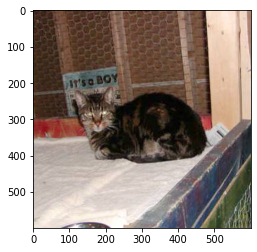

In [16]:
img=open_image(test_cats[78])
pyplot.imshow(img)
print(np.array([img]).shape)
model.predict(np.array([img]))

In [17]:
model.evaluate(training_dataset)

1000/1000 [==============================] - 114s 114ms/step - loss: 0.7497 - accuracy: 0.8089


[0.7496526837348938, 0.8088750243186951]

In [18]:
model.evaluate(test_dataset)

250/250 [==============================] - 29s 114ms/step - loss: 1.3160 - accuracy: 0.7545


[1.3160312175750732, 0.7544999718666077]

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 600, 600, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 600, 600, 64)      1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 600, 600, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 600, 600, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 200, 200, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 128)     73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 200, 200, 128)     0     

In [20]:
model2_input=keras.layers.Input(shape=[image_size[1],image_size[0],3])
model2_block_1=keras.layers.Conv2D(64,5,padding='same')(model2_input)
model2_block_1=tf.keras.layers.LeakyReLU()(model2_block_1)
model2_block_1=tf.keras.layers.Dropout(.1)(model2_block_1)
model2_block_1=keras.layers.MaxPool2D((3,3))(model2_block_1)

model2_block_2=keras.layers.Conv2D(128,5,padding='same')(model2_block_1)
model2_block_2=tf.keras.layers.LeakyReLU()(model2_block_2)
model2_block_2=tf.keras.layers.Dropout(.1)(model2_block_2)
model2_block_2=keras.layers.MaxPool2D((3,3))(model2_block_2)

model2_block_3=keras.layers.Conv2D(256,5,padding='same')(model2_block_2)
model2_block_3=tf.keras.layers.LeakyReLU()(model2_block_3)
model2_block_3=tf.keras.layers.Dropout(.1)(model2_block_3)
model2_block_3=keras.layers.MaxPool2D((3,3))(model2_block_3)

model2_block_4=keras.layers.Conv2D(512,5,padding='same')(model2_block_3)
model2_block_4=tf.keras.layers.LeakyReLU()(model2_block_4)
model2_block_4=tf.keras.layers.Dropout(.1)(model2_block_4)
model2_block_4=keras.layers.MaxPool2D((3,3))(model2_block_4)

model2_global=keras.layers.GlobalAveragePooling2D()(model2_block_4)

model2_fc=keras.layers.Dense(100)(model2_global)

model2_fc=keras.layers.Dense(100)(model2_fc)
model2_out=keras.layers.Dense(2,activation='softmax')(model2_fc)
model2=tf.keras.Model(inputs=model2_input,outputs=model2_out)
loss_fn = keras.losses.SparseCategoricalCrossentropy()
model2.compile(loss=loss_fn, optimizer='adam', metrics=['accuracy'])
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 600, 600, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 600, 600, 64)      4864      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 600, 600, 64)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 600, 600, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 200, 200, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 200, 200, 128)     204928    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 200, 200, 128)     0   

In [21]:
# model2.fit(training_dataset,epochs=40)

In [22]:
# model2.fit(training_dataset,epochs=40)

In [23]:
# model2.fit(training_dataset,epochs=100,validation_data=test_dataset)

In [24]:
model2=keras.models.load_model('model2')

In [25]:
model2.evaluate(training_dataset)

1000/1000 [==============================] - 123s 116ms/step - loss: 10.4150 - accuracy: 0.5116


[10.414998054504395, 0.5116249918937683]

In [26]:
model2.evaluate(test_dataset)

250/250 [==============================] - 29s 116ms/step - loss: 11.0191 - accuracy: 0.5090


[11.019081115722656, 0.5090000033378601]

In [27]:
model3_input=keras.layers.Input(shape=[image_size[1],image_size[0],3])
model3_block_1=keras.layers.Conv2D(64,3,padding='same')(model3_input)
model3_block_1=tf.keras.layers.LeakyReLU()(model3_block_1)
# model3_block_1=tf.keras.layers.Dropout(.1)(model3_block_1)
model3_block_1=keras.layers.MaxPool2D((3,3))(model3_block_1)

model3_block_2=keras.layers.Conv2D(128,3,padding='same')(model3_block_1)
model3_block_2=tf.keras.layers.LeakyReLU()(model3_block_2)
# model3_block_2=tf.keras.layers.Dropout(.1)(model3_block_2)
model3_block_2=keras.layers.MaxPool2D((3,3))(model3_block_2)

model3_block_3=keras.layers.Conv2D(256,3,padding='same')(model3_block_2)
model3_block_3=tf.keras.layers.LeakyReLU()(model3_block_3)
# model3_block_3=tf.keras.layers.Dropout(.1)(model3_block_3)
model3_block_3=keras.layers.MaxPool2D((3,3))(model3_block_3)

model3_block_4=keras.layers.Conv2D(512,3,padding='same')(model3_block_3)
model3_block_4=tf.keras.layers.LeakyReLU()(model3_block_4)
# model3_block_4=tf.keras.layers.Dropout(.1)(model3_block_4)
model3_block_4=keras.layers.MaxPool2D((3,3))(model3_block_4)

model3_global=keras.layers.GlobalAveragePooling2D()(model3_block_4)

model3_fc=keras.layers.Dense(100)(model3_global)
model3_fc=keras.layers.Dense(100)(model3_fc)
model3_out=keras.layers.Dense(2,activation='softmax')(model3_fc)
model3=tf.keras.Model(inputs=model3_input,outputs=model3_out)
loss_fn = keras.losses.SparseCategoricalCrossentropy()
model3.compile(loss=loss_fn, optimizer='adam', metrics=['accuracy'])
# model.fit(training_dataset,epochs=10)


In [28]:
model3.fit(training_dataset,epochs=100)

Epoch 1/100
1000/1000 [==============================] - 124s 112ms/step - loss: 0.7112 - accuracy: 0.5004
Epoch 2/100
1000/1000 [==============================] - 113s 113ms/step - loss: 1.3412 - accuracy: 0.5379
Epoch 3/100
1000/1000 [==============================] - 113s 113ms/step - loss: 0.6811 - accuracy: 0.5504
Epoch 4/100
1000/1000 [==============================] - 113s 113ms/step - loss: 0.6877 - accuracy: 0.5374
Epoch 5/100
1000/1000 [==============================] - 112s 112ms/step - loss: 0.6898 - accuracy: 0.5300
Epoch 6/100
1000/1000 [==============================] - 113s 113ms/step - loss: 0.7077 - accuracy: 0.5283
Epoch 7/100
1000/1000 [==============================] - 113s 113ms/step - loss: 0.7178 - accuracy: 0.5434
Epoch 8/100
1000/1000 [==============================] - 112s 112ms/step - loss: 0.7979 - accuracy: 0.5447
Epoch 9/100
1000/1000 [==============================] - 113s 113ms/step - loss: 1.2047 - accuracy: 0.5422
Epoch 10/100
1000/1000 [=============

KeyboardInterrupt: 

In [31]:
model3.save('model3')

INFO:tensorflow:Assets written to: model3/assets


In [29]:
model3.evaluate(test_dataset)

250/250 [==============================] - 29s 117ms/step - loss: 0.8140 - accuracy: 0.8770


[0.8139869570732117, 0.8769999742507935]

In [30]:
model3.evaluate(training_dataset)

1000/1000 [==============================] - 116s 116ms/step - loss: 0.0223 - accuracy: 0.9916


[0.02225313149392605, 0.9916250109672546]

In [39]:
model4_input=keras.layers.Input(shape=[image_size[1],image_size[0],3])
model4_block_1=keras.layers.Conv2D(64,3,padding='same')(model4_input)
model4_block_1=tf.keras.layers.LeakyReLU()(model4_block_1)
model4_block_1=tf.keras.layers.BatchNormalization()(model4_block_1)
model4_block_1=keras.layers.MaxPool2D((3,3))(model4_block_1)

model4_block_2=keras.layers.Conv2D(128,3,padding='same')(model4_block_1)
model4_block_2=tf.keras.layers.LeakyReLU()(model4_block_2)
model4_block_2=tf.keras.layers.BatchNormalization()(model4_block_2)
model4_block_2=keras.layers.MaxPool2D((3,3))(model4_block_2)

model4_block_3=keras.layers.Conv2D(256,3,padding='same')(model4_block_2)
model4_block_3=tf.keras.layers.LeakyReLU()(model4_block_3)
model4_block_3=tf.keras.layers.BatchNormalization()(model4_block_3)
model4_block_3=keras.layers.MaxPool2D((3,3))(model4_block_3)

model4_block_4=keras.layers.Conv2D(512,3,padding='same')(model4_block_3)
model4_block_4=tf.keras.layers.LeakyReLU()(model4_block_4)
model4_block_4=tf.keras.layers.BatchNormalization()(model4_block_4)
model4_block_4=keras.layers.MaxPool2D((3,3))(model4_block_4)

model4_global=keras.layers.GlobalAveragePooling2D()(model4_block_4)

model4_fc=keras.layers.Dense(100)(model4_global)
model4_fc=keras.layers.Dense(100)(model4_fc)
model4_out=keras.layers.Dense(2,activation='softmax')(model4_fc)
model4=tf.keras.Model(inputs=model4_input,outputs=model4_out)
loss_fn = keras.losses.SparseCategoricalCrossentropy()
model4.compile(loss=loss_fn, optimizer='adam', metrics=['accuracy'])
# model.fit(training_dataset,epochs=10)
model4.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 600, 600, 3)]     0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 600, 600, 64)      1792      
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 600, 600, 64)      0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 600, 600, 64)      256       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 200, 200, 64)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 200, 200, 128)     73856     
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 200, 200, 128)     0   

In [33]:
model4.evaluate(training_dataset)

1000/1000 [==============================] - 116s 115ms/step - loss: 0.6932 - accuracy: 0.4970


[0.6931890249252319, 0.49287500977516174]

In [34]:
model4.fit(training_dataset,epochs=50)

Epoch 1/50
1000/1000 [==============================] - 112s 112ms/step - loss: 0.6973 - accuracy: 0.5871
Epoch 2/50
1000/1000 [==============================] - 113s 113ms/step - loss: 0.6482 - accuracy: 0.6269
Epoch 3/50
1000/1000 [==============================] - 115s 114ms/step - loss: 0.6259 - accuracy: 0.6593
Epoch 4/50
1000/1000 [==============================] - 113s 113ms/step - loss: 0.5945 - accuracy: 0.6854
Epoch 5/50
1000/1000 [==============================] - 114s 114ms/step - loss: 0.5705 - accuracy: 0.7045
Epoch 6/50
1000/1000 [==============================] - 114s 114ms/step - loss: 0.5695 - accuracy: 0.7197
Epoch 7/50
1000/1000 [==============================] - 114s 114ms/step - loss: 0.5316 - accuracy: 0.7415
Epoch 8/50
1000/1000 [==============================] - 113s 113ms/step - loss: 0.5052 - accuracy: 0.7567
Epoch 9/50
1000/1000 [==============================] - 114s 114ms/step - loss: 0.4705 - accuracy: 0.7811
Epoch 10/50
1000/1000 [=======================

KeyboardInterrupt: 

In [35]:
model4.evaluate(test_dataset)

250/250 [==============================] - 29s 115ms/step - loss: 1.0777 - accuracy: 0.6940


[1.0776797533035278, 0.6940000057220459]

In [36]:
# model4.save('model4')

INFO:tensorflow:Assets written to: model4/assets


In [40]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,profile_batch = '0,10')
model4.fit(training_dataset,epochs=50,callbacks=[tensorboard_callback])

Epoch 1/50
1000/1000 [==============================] - 119s 119ms/step - loss: 0.5445 - accuracy: 0.7268
Epoch 2/50
1000/1000 [==============================] - 119s 119ms/step - loss: 0.5222 - accuracy: 0.7473
Epoch 3/50
1000/1000 [==============================] - 119s 119ms/step - loss: 0.4806 - accuracy: 0.7742
Epoch 4/50
1000/1000 [==============================] - 119s 119ms/step - loss: 0.4608 - accuracy: 0.7857
Epoch 5/50
1000/1000 [==============================] - 122s 122ms/step - loss: 0.4262 - accuracy: 0.8120
Epoch 6/50
1000/1000 [==============================] - 120s 120ms/step - loss: 0.3683 - accuracy: 0.8374
Epoch 7/50
1000/1000 [==============================] - 119s 119ms/step - loss: 0.3593 - accuracy: 0.8434
Epoch 8/50
1000/1000 [==============================] - 119s 119ms/step - loss: 0.3205 - accuracy: 0.8622
Epoch 9/50
1000/1000 [==============================] - 123s 123ms/step - loss: 0.2679 - accuracy: 0.8844
Epoch 11/50
1000/1000 [=======================